# **Aprendizado Profundo para Reconhecimento Visual**
#### Universidade Federal de São Carlos (UFSCar) - campus Sorocaba
#### Projeto prático

**Integrantes**:<br>
Giovanna Aguiar de Castro<br>
Matheus Vargas Volpon Berto

**Professor responsável**:<br>
Prof. Dr. Jurandy Gomes de Almeida Júnior

**Atribuições**  

Este projeto foi realizado a partir de uma base de dados previamente existente no Kaggle, disponível através [deste link](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small). Além disso, parte dos códigos executados neste notebook, especialmente ao que se refere à análise exploratória, podem ter sido aproveitados de trabalhos já realizados e publicamente disponíveis, estando alguns principais listados abaixo:
    
1. [Base/Denoising Autoencoder + Dimension Reduction](https://www.kaggle.com/code/ohseokkim/base-denoising-autoencoder-dimension-reduction)
2. [The prediction of color tags](https://www.kaggle.com/code/rrighart/the-prediction-of-color-tags)
3. [Fashion Product Images Classifier](https://www.kaggle.com/code/paramaggarwal/fashion-product-images-classifier)

## Configurações de recursos

### Bibliotecas e pacotes

In [300]:
%pip install tensorflow --quiet
%pip install ydata-profiling --quiet
%pip install opencv-python --quiet
%pip install shap --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [301]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import os, cv2, shap, warnings
from math import ceil

from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from skimage.segmentation import slic
from IPython.display import Image, display

import tensorflow as tf
import keras
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_v2_preprocess, decode_predictions as mobilenetv2_decode
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_v3_preprocess, decode_predictions as inceptionv3_decode
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, dot, Reshape
from tensorflow.python.keras.utils.data_utils import Sequence
from PIL import Image

import random
from random import shuffle 
from tqdm import tqdm

In [302]:
print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.15.0


### Constantes

In [303]:
#DATASET_PATH = "/content/drive/MyDrive/UFSCAR/23-2/APRENDIZADO PROFUNDO/TRABALHO/kaggle-dataset/"
#DATASET_PATH = "/Users/giovannacastro/Documents/DRIVE-PESSOAL/UFSCAR/23-2/APRENDIZADO PROFUNDO/TRABALHO/kaggle-dataset 2/"
DATASET_PATH = '../data/kaggle-dataset/'
OUTPUT_IMAGES_PATH = '../imgs/'
BATCH_SIZE = 32
IMG_SIZE = (80, 60)
TEST_IMAGES_IDS = [40524, 44188, 56314, 58621]

### Funções

In [304]:
def plot_figures(figures, nrows=1, ncols=1, figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout()

def img_path(img, folder='train', format='jpg'):
    """Returns the path of an image inside the folder of training samples.

    Parameters
    ----------
    img : filename
    """

    return DATASET_PATH + folder + "/" + str(img) + '.' + format

def load_image(img):
    """Load and image given it path.

    Parameters
    ----------
    img : filename
    """

    return cv2.imread(img_path(img))

def load_images_from_folder(folder):
    """Load all images present in a given folder.

    Parameters
    ----------
    folder : path of thr folder that contains the images    
    """

    images = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            images.append(img)
    return images

def load_images_from_list(names_list):
    """Load all images present in a given list of filenames.

    Parameters
    ----------
    names_list : list with the filenames    
    """

    images = []
    for filename in names_list:
        img = cv2.imread(DATASET_PATH + '/test_images/{}'.format(filename))
        if img is not None:
            images.append(img)

    return images

def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out



def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

def train_mobilenet_v2(df_train, target_size):
    image_generator = ImageDataGenerator(
        validation_split=0.2
    )

    training_generator = image_generator.flow_from_dataframe(
        dataframe=df_train,
        directory=DATASET_PATH + "train",
        x_col="image",
        y_col="subCategory",
        target_size=target_size,
        batch_size=BATCH_SIZE,
        subset="training"
    )

    validation_generator = image_generator.flow_from_dataframe(
        dataframe=df_train,
        directory=DATASET_PATH + "train",
        x_col="image",
        y_col="subCategory",
        target_size=target_size,
        batch_size=BATCH_SIZE,
        subset="validation"
    )

    classes = len(training_generator.class_indices)

    base_model = MobileNetV2(input_shape=target_size+(3,), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    model.fit(
        x=training_generator,
        #steps_per_epoch=ceil(0.8 * (df_train.size / BATCH_SIZE)),

        validation_data=validation_generator,
        validation_steps=ceil(0.2 * (df_train.size / BATCH_SIZE)),

        epochs=10,
        verbose=1
    )

    model.save('../models/mobilenet_v2_{}x{}_fashion.h5'.format(target_size[0], target_size[1]))
    return model

def train_inception_v3(df_train, target_size):
    image_generator = ImageDataGenerator(
        validation_split=0.2
    )

    training_generator = image_generator.flow_from_dataframe(
        dataframe=df_train,
        directory=DATASET_PATH + "train",
        x_col="image",
        y_col="subCategory",
        target_size=target_size,
        batch_size=BATCH_SIZE,
        subset="training",
        preprocessing_function=inception_v3_preprocess,
    )

    validation_generator = image_generator.flow_from_dataframe(
        dataframe=df_train,
        directory=DATASET_PATH + "train",
        x_col="image",
        y_col="subCategory",
        target_size=target_size,
        batch_size=BATCH_SIZE,
        subset="validation",
        preprocessing_function=inception_v3_preprocess,
    )

    classes = len(training_generator.class_indices)

    input_target = Input((299, 299, 3))
    base_model = InceptionV3(input_shape=target_size+(3,), include_top=False, weights='imagenet', pooling='avg', input_tensor=input_target)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(classes, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    model.fit(
        x=training_generator,
        #steps_per_epoch=ceil(0.8 * (df_train.size / BATCH_SIZE)),

        validation_data=validation_generator,
        validation_steps=ceil(0.2 * (df_train.size / BATCH_SIZE)),

        epochs=5,
        verbose=1
    )

    model.save('../models/inception_v3_{}x{}_fashion.h5'.format(target_size[0], target_size[1]))
    return model

def shap_interpretability(file_id, model, model_name, preprocessing_function, size):
    def f(z):
        return model.predict(preprocessing_function(mask_image(z, segments_slic, img_orig, 255)))

    file ="../data/kaggle-dataset/test/{}.jpg".format(file_id)

    CLASS_NAMES = list(df_train['subCategory'].unique())
    classes =  [str(x) for x in range(0, len(CLASS_NAMES))]
    mapping = dict(zip(classes, CLASS_NAMES))

    for key, value in mapping.items():
        mapping[key] = ['', value]

    img = image.load_img(file, target_size=size)
    img_orig = image.img_to_array(img)

    segments_slic = slic(np.array(img), compactness=1, sigma=3)

    explainer = shap.KernelExplainer(f, np.zeros((1,50)))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

    preds = model.predict(preprocessing_function(np.expand_dims(img_orig.copy(), axis=0)))
    top_preds = np.argsort(-preds)
    inds = top_preds[0]

    colors = []
    for l in np.linspace(1,0,100):
        colors.append((245/255,39/255,87/255,l))
    for l in np.linspace(0,1,100):
        colors.append((24/255,196/255,93/255,l))
        
    cm = LinearSegmentedColormap.from_list("shap", colors)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    fig.suptitle(model_name)
    axes[0].imshow(img)
    axes[0].axis('off')
    max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
    for i in range(1):
        m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
        #axes[i+1].set_title(mapping[str(inds[i])][1])
        axes[i+1].imshow(img.convert('LA'), alpha=0.15)
        im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
        axes[i+1].axis('off')
    cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="Valores SHAP", orientation="horizontal", aspect=60)
    cb.outline.set_visible(False)
    #plt.title(mapping[str(inds[0])][1])
    plt.savefig(OUTPUT_IMAGES_PATH + 'shap_plot_' + str(file_id) + '_' + ''.join(model_name.lower().split(' ')) + '.jpg')
    plt.show()

def gradcam_interpretability(file_id, model, model_name, preprocessing_function, img_size):
    filepath = img_path(file_id, folder='test')

    CLASS_NAMES = list(df_train['subCategory'].unique())
    classes =  [str(x) for x in range(0, len(CLASS_NAMES))]
    mapping = dict(zip(classes, CLASS_NAMES))

    for key, value in mapping.items():
        mapping[key] = ['', value]

    def get_img_array(filepath, size):
        ## `img` is a PIL image 
        img = keras.utils.load_img(filepath, target_size=size)
        array = keras.utils.img_to_array(img)
        ## We add a dimension to transform our array into a "batch"
        array = np.expand_dims(array, axis=0)
        return array

    def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        ## First, we create a model that maps the input image to the activations
        ## of the last conv layer as well as the output predictions
        grad_model = keras.models.Model(
            model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
        )

        ## Then, we compute the gradient of the top predicted class for our input image
        ## for the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        ## We are doing transfer learning on last layer
        grads = tape.gradient(class_channel, last_conv_layer_output)

        ## This is a vector where each entry is the mean intensity of the gradient
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        ## calculates a heatmap highlighting the regions of importance in an image
        ## for a specific 
        ## predicted class by combining the output of the last convolutional layer
        ## with the pooled gradients.
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        ## For visualization purpose
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()
    
    ## Preparing the image
    img_array = preprocessing_function(get_img_array(filepath, size=img_size))

    ## Remove last layer's softmax(transfer learning)
    model.layers[-1].activation = None

    preds = model.predict(img_array)
    top_preds = np.argsort(-preds)
    inds = top_preds[0]

    # Iterando reversamente sobre as camadas para encontrar a última camada de convolução
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break

    ## Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    ## visulization of heatmap
    #plt.matshow(heatmap)
    #plt.show()

    def save_and_display_gradcam(filepath, heatmap, alpha=0.4):
        ## Loading the original image
        img = keras.utils.load_img(filepath)
        img = keras.utils.img_to_array(img)

        ## Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        ## Use jet colormap to colorize heatmap
        jet = matplotlib.colormaps["jet"]

        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        ## Create an image with RGB colorized heatmap
        jet_heatmap = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.utils.img_to_array(jet_heatmap)

        ## Superimpose the heatmap on original image
        Superimposed_img = jet_heatmap * alpha + img
        Superimposed_img = keras.utils.array_to_img(Superimposed_img)

        ## Save the superimposed image
        cam_path = OUTPUT_IMAGES_PATH + "camgrad_plot_" + str(file_id) + '_' + ''.join(model_name.lower().split(' ')) + '_' + mapping[str(inds[0])][1].lower() + '.jpg'
        Superimposed_img.save(cam_path)

        ## Displaying Grad CAM
        display(Image(cam_path))


    save_and_display_gradcam(filepath, heatmap)

def gradcam_plot_activation_map(model, model_name, file_id, target_size):
    def label_image_one_hot_encoder(img):
        ## Helper for process_data
        label = img.split('_')[0]
        if label == 'cat': return 0
        elif label == 'dog': return 1

    def process_data(image_list, DATA_FOLDER, IMG_SIZE):
        ## Helper for manual_pre_process
        ## Creates an array of images, labels, and file path
        ## Shuffles the array before returning
        data_df = []
        for img in tqdm(image_list):
            path = os.path.join(DATA_FOLDER, img)
            label = label_image_one_hot_encoder(img)
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data_df.append([np.array(img), np.array(label), path])
        shuffle(data_df)
        return data_df
    
    def manual_pre_process(dir, IMG_SIZE):
        '''
        Creates an array of images, labels, and files from a directory of image files
        
        Args:
            dir: string, folder name
            IMG_SIZE: int, image height and width

        Returns 
            X: (n x IMG_SIZE x IMG_SIZE) numpy array of images
            y: (n,) numpy array of labels
            files: (n,) numpy array of files

        '''
        image_lst = os.listdir(dir)
        data_df = process_data(image_lst, dir, IMG_SIZE)
        X = np.array([i[0] for i in data_df]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
        y = np.array([i[1] for i in data_df])
        files = np.array([i[2] for i in data_df])
        return X, y, files
    
    def decode_prediction(pred):
        # This function thresholds a probability to produce a prediction
        pred = tf.where(pred < 0.5, 0, 1)
        return pred.numpy()

    def GradCam(model, img_array, layer_name, eps=1e-8):
        '''
        Creates a grad-cam heatmap given a model and a layer name contained with that model
        

        Args:
        model: tf model
        img_array: (img_width x img_width) numpy array
        layer_name: str


        Returns 
        uint8 numpy array with shape (img_height, img_width)

        '''

        gradModel = Model(
                inputs=[model.inputs],
                outputs=[model.get_layer(layer_name).output,
                    model.output])
        
        with tf.GradientTape() as tape:
                # cast the image tensor to a float-32 data type, pass the
                # image through the gradient model, and grab the loss
                # associated with the specific class index
            inputs = tf.cast(img_array, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, 0]
            
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
            # the convolution and guided gradients have a batch dimension
            # (which we don't need) so let's grab the volume itself and
            # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
            # as weights, compute the ponderation of the filters with
            # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    
        # grab the spatial dimensions of the input image and resize
            # the output class activation map to match the input image
            # dimensions
        (w, h) = (img_array.shape[2], img_array.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
            # normalize the heatmap such that all values lie in the range
            # [0, 1], scale the resulting values to the range [0, 255],
            # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        # heatmap = (heatmap * 255).astype("uint8")
            # return the resulting heatmap to the calling function
        return heatmap


    def sigmoid(x, a, b, c):
        return c / (1 + np.exp(-a * (x-b)))

    def superimpose(img_bgr, cam, thresh, emphasize=False):
        
        '''
        Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
        

        Args:
        image: (img_width x img_height x 3) numpy array
        grad-cam heatmap: (img_width x img_width) numpy array
        threshold: float
        emphasize: boolean

        Returns 
        uint8 numpy array with shape (img_height, img_width, 3)

        '''
        heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
        if emphasize:
            heatmap = sigmoid(heatmap, 50, thresh, 1)
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        
        hif = .8
        superimposed_img = heatmap * hif + img_bgr
        superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
        superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
        
        return superimposed_img_rgb
    
    def fuse_layers(layers, model, img, emphasize=False):
        '''
            Fuses grad-cam heatmaps from a list of model layers into a single heatmap
            and superimposes the heatmap onto an image.

            Args:
            layers: list of strings
            model: tf model
            img: (img_width x img_height x 3) numpy array


            Returns 
            uint8 numpy array with shape (img_height, img_width, 3)

            '''
        cams = []
        for layer in layers:
            cam = GradCam(model, np.expand_dims(img, axis=0), layer)
            cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
            cams.append(cam)

        fused = np.mean(cams, axis=0)
        superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)

        return superimposed
    
    val_imgs = '../data/kaggle-dataset/test/'
    CLASS_NAMES = list(df_train['subCategory'].unique())
    classes =  [x for x in range(0, len(CLASS_NAMES))]
    mapping = dict(zip(classes, CLASS_NAMES))

    for key, value in mapping.items():
        mapping[key] = value

    class_info = mapping

    X, y, files = manual_pre_process(val_imgs, target_size)

    image_idx = np.where(files == f'../data/kaggle-dataset/test/{file_id}.jpg')[0][0]

    img = X[image_idx]
    label = y[image_idx]
    path = files[image_idx]

    pred_raw = model.predict(np.expand_dims(img, axis=0))[0][0]
    pred = decode_prediction(pred_raw)
    pred_label = class_info[pred]

    #plt.figure(figsize=(10, 10))
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #plt.axis('off')
    #plt.title(pred_label + ' ' + str(pred_raw))

    conv2D_layers = [layer.name for layer in reversed(model.layers) if isinstance(layer, tf.keras.layers.Conv2D)]
    activation_layers = [layer.name for layer in reversed(model.layers) if layer.__class__.__name__ == 'ReLU' or 'activation' in layer.name.lower()]
    all_layers = [layer.name for layer in reversed(model.layers) if (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv2D) or 'conv2d' in layer.name.lower())]

    fused = fuse_layers(all_layers, model, img, True)
    convs = fuse_layers(activation_layers, model, img, True)

    plt.figure(figsize=(18, 8))
    plt.suptitle(model_name)
    ax = plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Imagem Original')
    ax = plt.subplot(1, 3, 2)
    plt.imshow(convs)
    plt.axis('off')
    plt.title('Grad-CAM Camada de Convolução')
    ax = plt.subplot(1, 3, 3)
    plt.imshow(fused)
    plt.axis('off')
    plt.title('Grad-CAM Camada de Ativação')

    plt.savefig(OUTPUT_IMAGES_PATH+'gradcam_plot_{}_{}.jpg'.format(file_id, ''.join(model_name.lower().split(' '))))

## Preparação de dados

In [305]:
df = pd.read_csv(DATASET_PATH + "styles.csv", on_bad_lines='skip')
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)

In [306]:
print('A pasta de teste já existe e contém pelo menos um arquivo png. Os DataFrames de treino e teste serão criados a partir das imagens das pastas existentes')
arquivos_jpg_teste = [arquivo for arquivo in os.listdir(DATASET_PATH + 'test/') if arquivo.lower().endswith(".jpg")]
df_test = df[df['image'].isin(arquivos_jpg_teste)]
df_test = df_test.reset_index(drop=True)

A pasta de teste já existe e contém pelo menos um arquivo png. Os DataFrames de treino e teste serão criados a partir das imagens das pastas existentes


In [307]:
df_train = df.merge(df_test, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
print('Quantidade de amostras para treinamento: {}'.format(len(df_train.index)))
print('Quantidade de amostras para teste: {}'.format(len(df_test.index)))

Quantidade de amostras para treinamento: 44379
Quantidade de amostras para teste: 45


## Análise exploratória

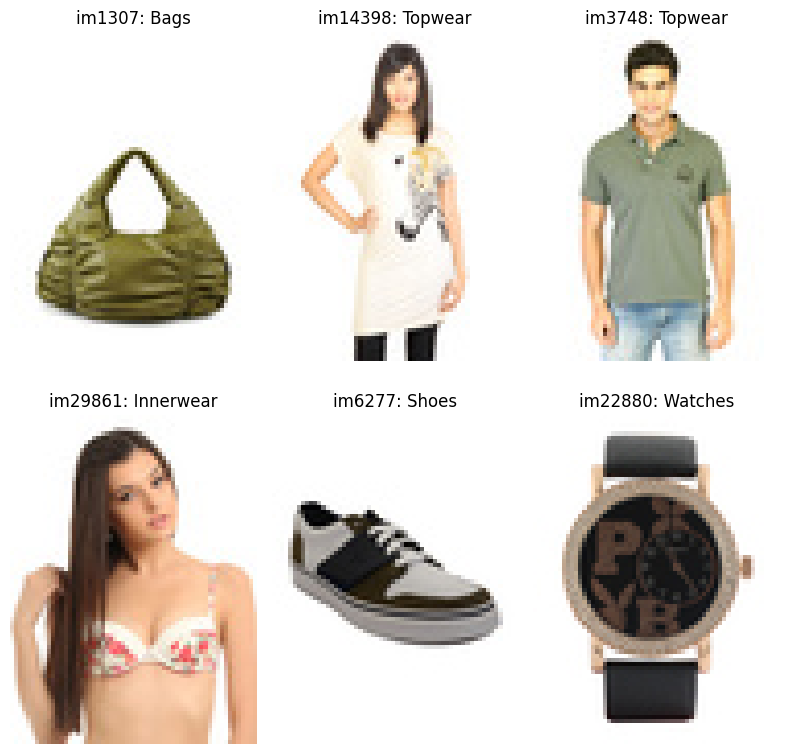

In [308]:
figures = {'im'+str(i)+': {}'.format(row.subCategory): load_image(int(row.image.split(".")[0])) for i, row in df_train.sample(6).iterrows()}
plot_figures(figures, 2, 3)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

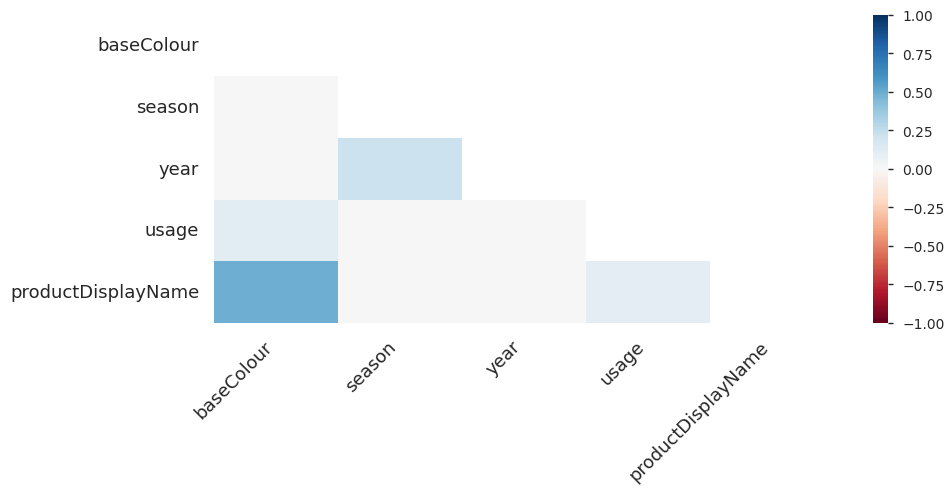

In [309]:
profile = ProfileReport(df_train, title='Automobile data', html={'style': {'full_width': True}})
profile.to_notebook_iframe()
profile.to_file("../docs/kaggle_dataset_report.html")

## Transferência de aprendizado a partir de modelos pré-treinados

### MobileNet V2

In [310]:
try:
    mobilenet_v2_model = tf.keras.saving.load_model('../models/mobilenet_v2_96x96_fashion.h5')

except:
    mobilenet_v2_model = train_mobilenet_v2(df_train, target_size=(96, 96))

### Inception V3

In [311]:
try:
    inception_v3_model = tf.keras.saving.load_model('../models/inception_v3_299x299_fashion.h5')

except:
    inception_v3_model = train_inception_v3(df_train, target_size=(299, 299))

## Análise de interpretabilidade com SHAP

### MobileNet V2

1/1 [==============================] - 1s 1s/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


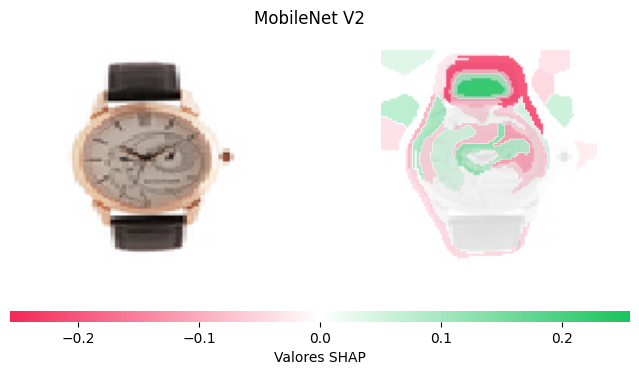

1/1 [==============================] - 0s 48ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


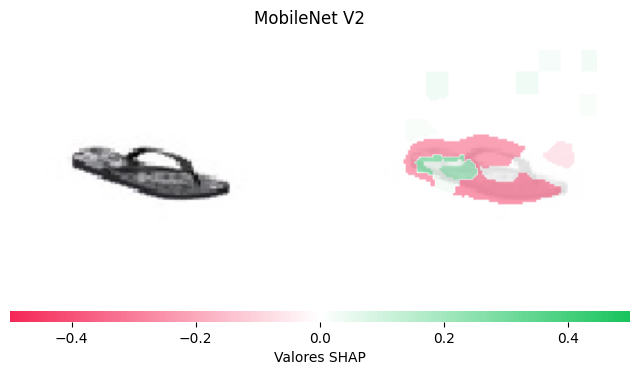

1/1 [==============================] - 0s 79ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 76ms/step


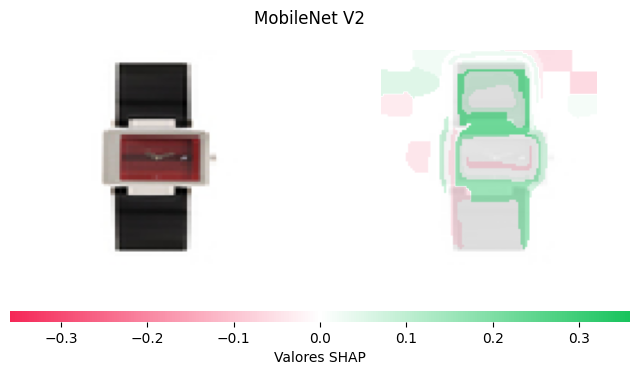

1/1 [==============================] - 0s 78ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


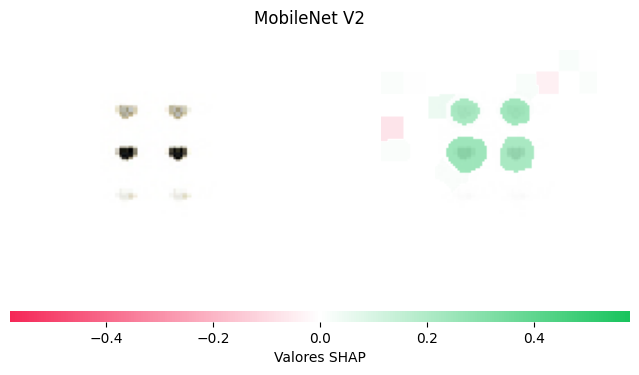

In [312]:
for image_id in TEST_IMAGES_IDS:
    shap_interpretability(image_id, mobilenet_v2_model, 'MobileNet V2', mobilenet_v2_preprocess, (96, 96))

### Inception V3

1/1 [==============================] - 4s 4s/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 298ms/step


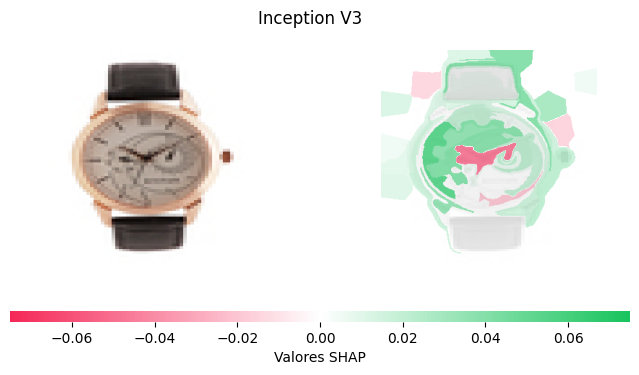

1/1 [==============================] - 0s 157ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 329ms/step


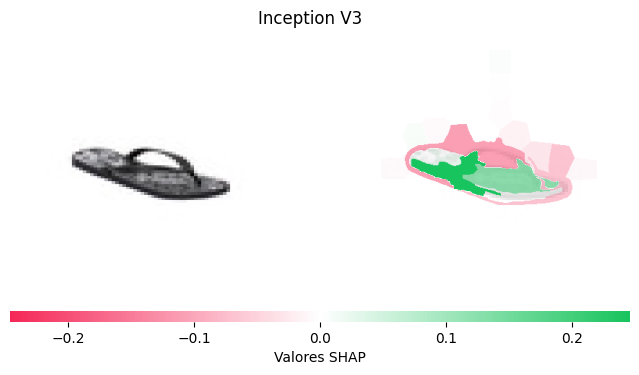

1/1 [==============================] - 0s 220ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 217ms/step


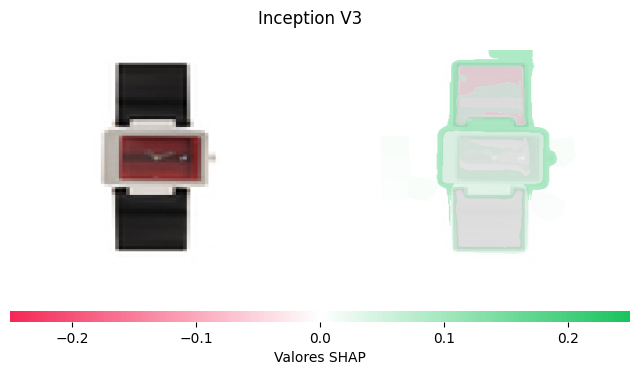

1/1 [==============================] - 0s 149ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 200ms/step


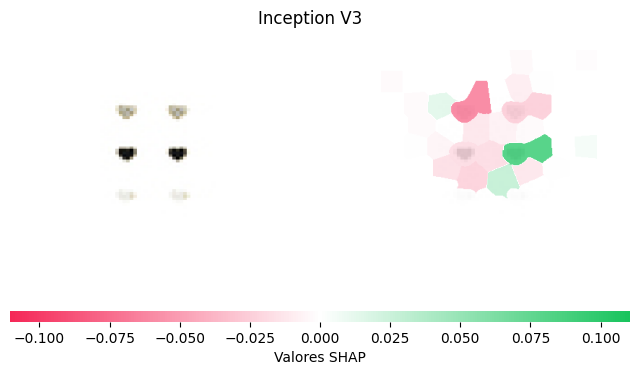

In [313]:
for image_id in TEST_IMAGES_IDS:
    shap_interpretability(image_id, inception_v3_model, 'Inception V3', inception_v3_preprocess, (299, 299))

## Análise de interpretabilidade com Grad-CAM

### MobileNet V2

  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:00<00:00, 357.73it/s]


1/1 [==============================] - 2s 2s/step


100%|██████████| 45/45 [00:00<00:00, 2663.80it/s]

1/1 [==============================] - 0s 50ms/step



100%|██████████| 45/45 [00:00<00:00, 976.73it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 54ms/step


100%|██████████| 45/45 [00:00<00:00, 2658.21it/s]

1/1 [==============================] - 0s 57ms/step


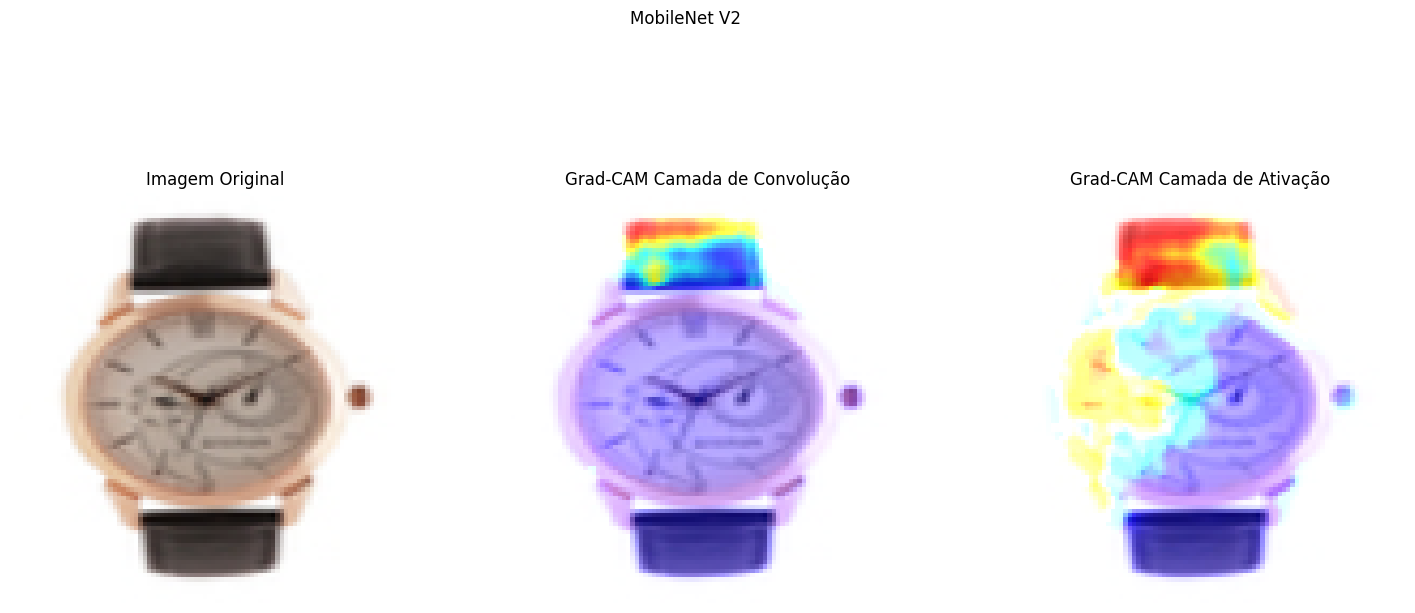

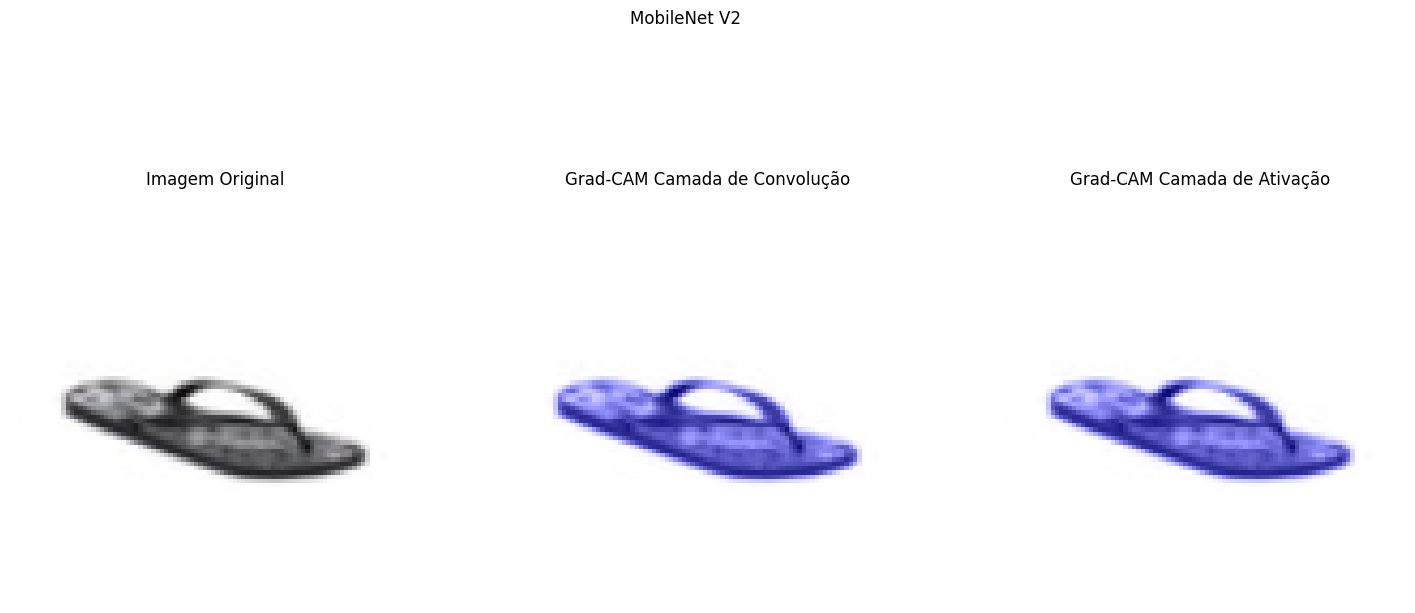

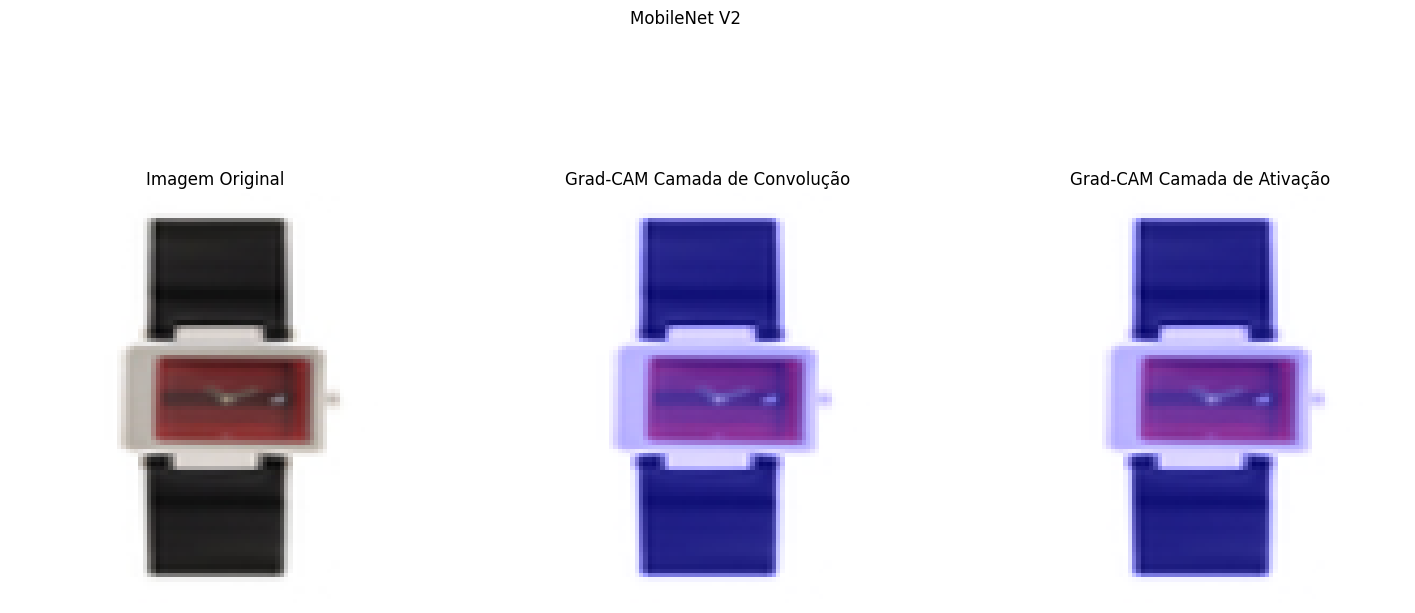

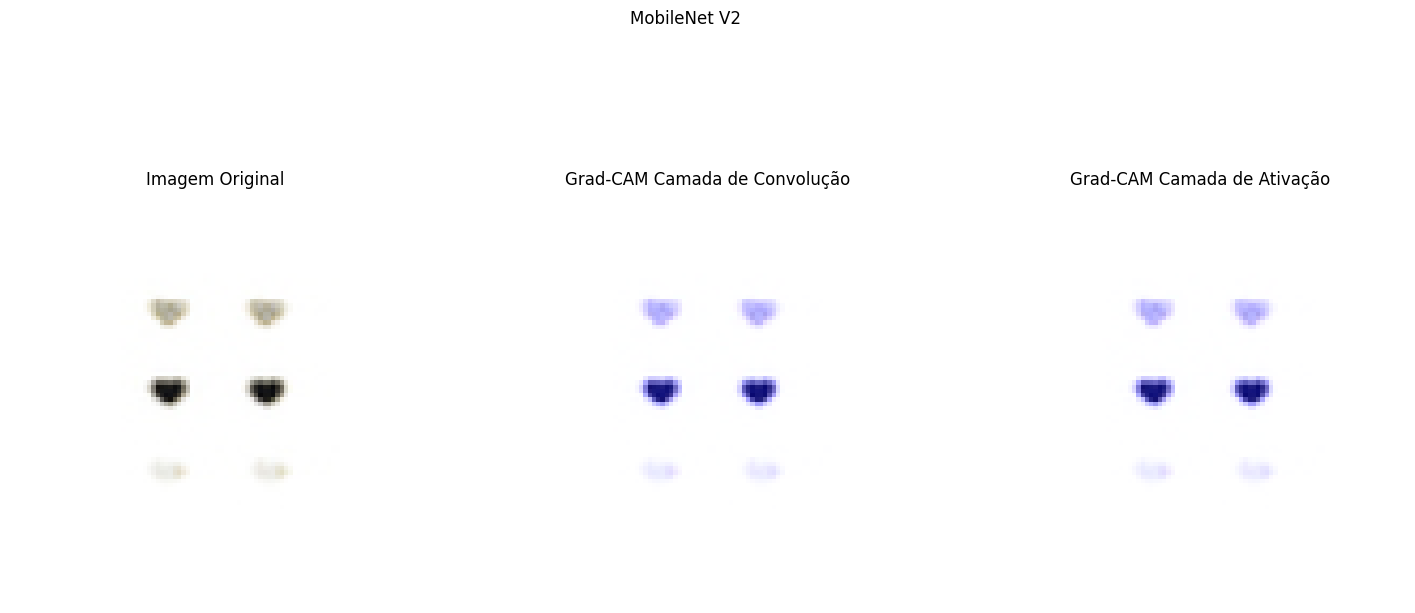

In [314]:
for image_id in TEST_IMAGES_IDS:
    gradcam_plot_activation_map(mobilenet_v2_model, 'MobileNet V2', image_id, 96)

### Inception V3

100%|██████████| 45/45 [00:00<00:00, 872.26it/s]


1/1 [==============================] - 2s 2s/step


100%|██████████| 45/45 [00:00<00:00, 893.90it/s]


1/1 [==============================] - 0s 144ms/step


100%|██████████| 45/45 [00:00<00:00, 612.24it/s]


1/1 [==============================] - 0s 183ms/step


100%|██████████| 45/45 [00:00<00:00, 864.83it/s]


1/1 [==============================] - 0s 167ms/step


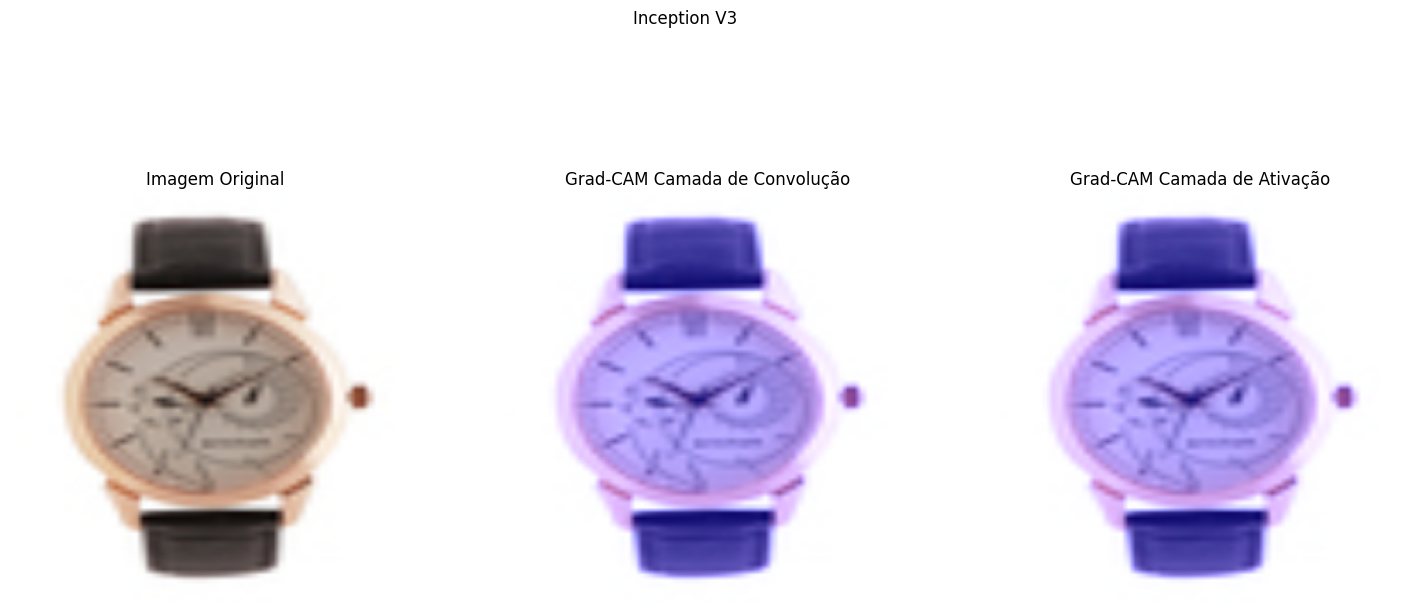

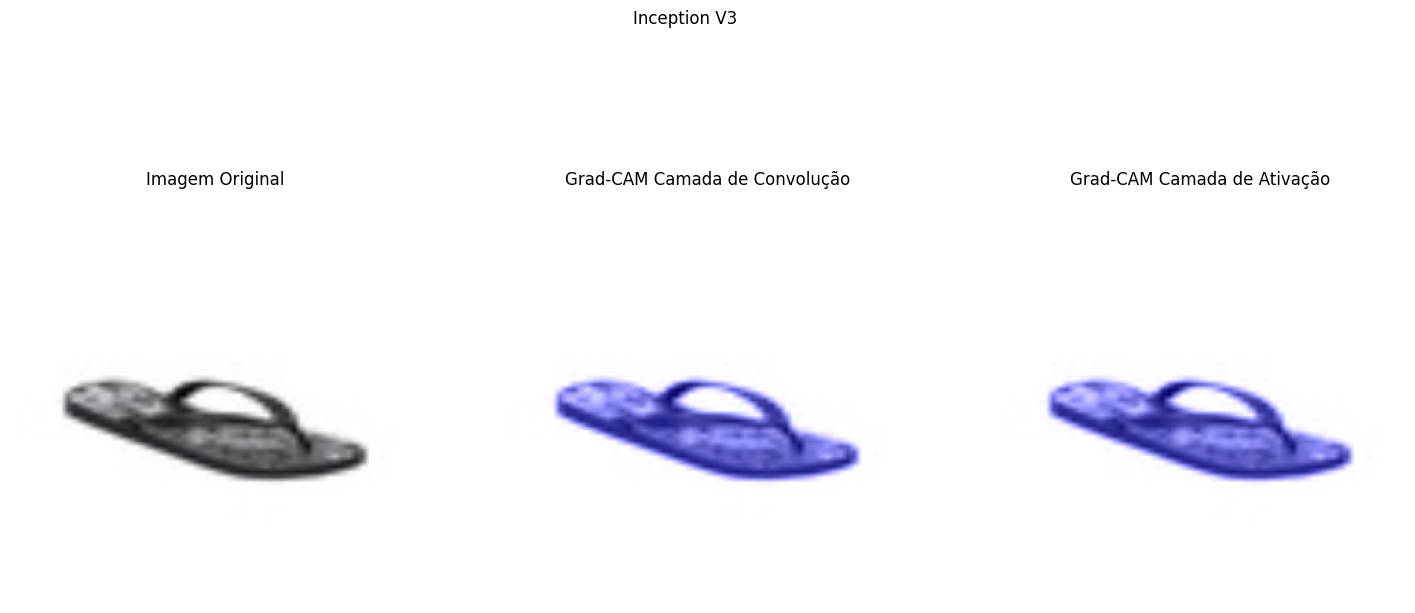

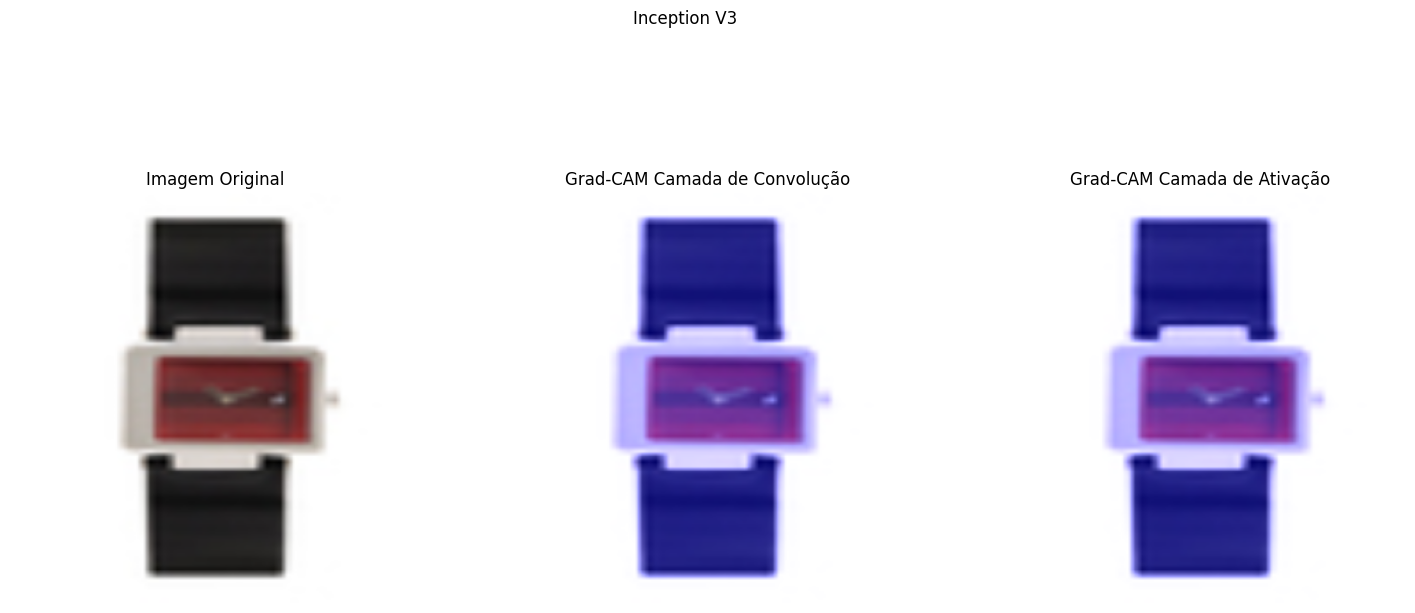

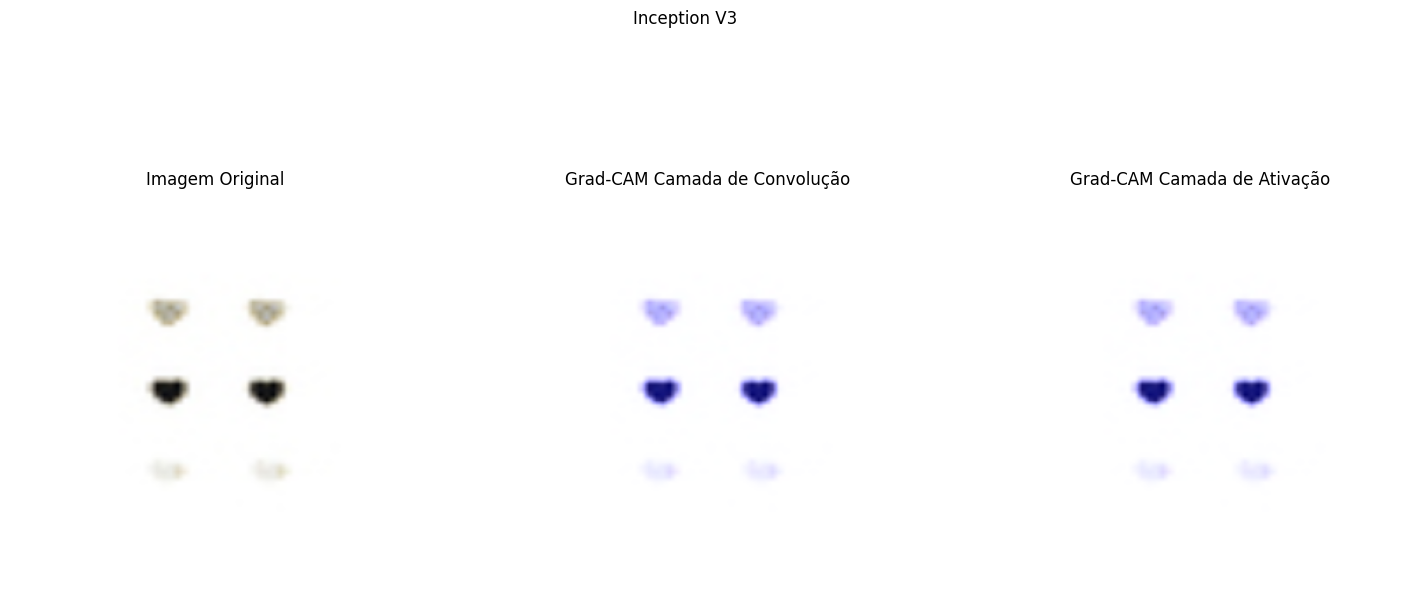

In [315]:
for image_id in TEST_IMAGES_IDS:
    gradcam_plot_activation_map(inception_v3_model, 'Inception V3', image_id, 299)